In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

### Load and Prepare the Dataset

In [56]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding='latin-1', 
                 header=None,
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'])

# Convert target: 4 is positive -> 1, 0 is negative -> 0
df['target'] = df['target'].replace(4, 1)

# Take a smaller sample for faster training (optional)
df = df.sample(100000, random_state=42)

# Display dataset info
print(f"Dataset size: {len(df)}")
print(df.head())

Dataset size: 100000
        target         ids                          date      flag  \
541200       0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
750          0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
766711       0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
285055       0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
705995       0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

                   user                                               text  
541200  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!   
750         sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...  
766711       sammydearr  @TiannaChaos i know  just family drama. its la...  
285055      Lamb_Leanne  School email won't open  and I have geography ...  
705995      yogicerdito                             upper airways problem   


###  Preprocess the Text Data

In [57]:
# Parameters
VOCAB_SIZE = 10000  # Number of most frequent words to keep
MAX_LEN = 50        # Maximum length of tweets (pad or truncate)
EMBEDDING_DIM = 100 # Dimension of word embeddings


In [58]:

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [59]:

# Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

In [60]:

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [61]:

# Pad sequences to make them uniform length
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')


In [62]:

# Get labels
y_train = train_df['target'].values
y_test = test_df['target'].values

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (80000, 50)
Test data shape: (20000, 50)


###  Build the Embedding Model

In [63]:
model = Sequential([
    # Embedding layer converts word indices to dense vectors
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    
    # Flatten the 2D output to 1D for dense layers
    Flatten(),
    
    # Hidden layer
    Dense(64, activation='relu'),
    
    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

model.summary()

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the Model

In [64]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.7069 - loss: 0.5539 - val_accuracy: 0.7703 - val_loss: 0.4721
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8273 - loss: 0.3864 - val_accuracy: 0.7592 - val_loss: 0.5088
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8959 - loss: 0.2522 - val_accuracy: 0.7475 - val_loss: 0.6797
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9416 - loss: 0.1500 - val_accuracy: 0.7418 - val_loss: 0.9222
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9657 - loss: 0.0915 - val_accuracy: 0.7364 - val_loss: 1.1626
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.9772 - loss: 0.0612 - val_accuracy: 0.7322 - val_loss: 1.4385
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9814 - loss: 0.0497 - val_accuracy: 0.7338 - val_loss: 1.7008
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.9850 -

###  Extract and Visualize Word Embeddings

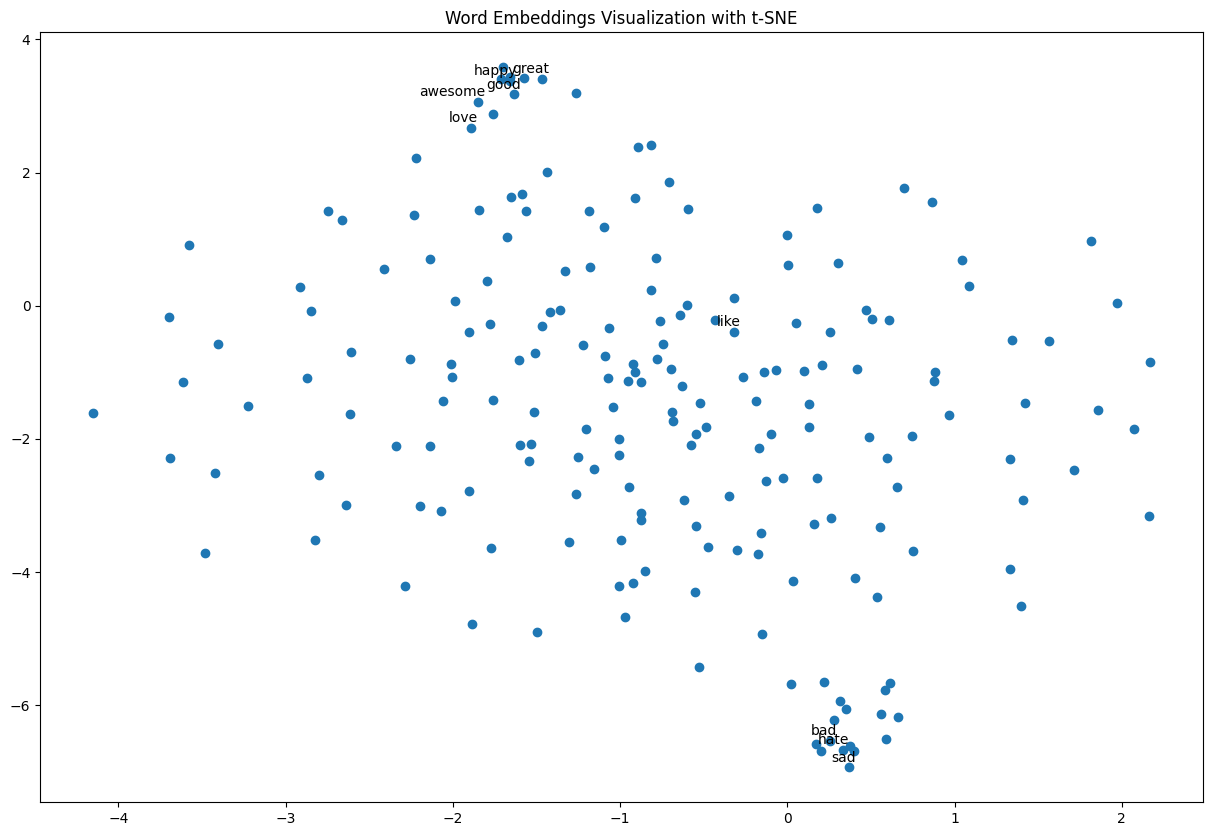

In [65]:
# Getting the embedding layer weights
embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]

# Gettting word index mapping
word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

# Selecting some words to visualize (top N most frequent)
num_words_to_plot = 200
words_to_visualize = [reverse_word_index.get(i, '') for i in range(1, num_words_to_plot+1)]
word_indices = [i for i in range(1, num_words_to_plot+1)]

# Gettting embeddings for selected words
word_vectors = embeddings[word_indices]

# Reducing the dimensionalities with t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the embeddings
plt.figure(figsize=(15, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# Annotate some interesting words
words_to_label = ['good', 'bad', 'happy', 'sad', 'love', 'hate', 
                 'great', 'terrible', 'awesome', 'awful', 'like', 'dislike']
for i, word in enumerate(words_to_visualize):
    if word in words_to_label:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), 
                    xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.title('Word Embeddings Visualization with t-SNE')
plt.show()

### Evaluation and Results

In [66]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Show some sample predictions
sample_texts = test_df['text'].head(3).tolist()
sample_labels = test_df['target'].head(3).tolist()

# Preprocess the sample texts
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Predict
predictions = model.predict(sample_padded).flatten()
predicted_labels = [1 if p > 0.5 else 0 for p in predictions]

# Display results
for text, true_label, pred_label, prob in zip(sample_texts, sample_labels, predicted_labels, predictions):
    print(f"\nTweet: {text[:100]}...")
    print(f"True Sentiment: {'Positive' if true_label else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if pred_label else 'Negative'} (confidence: {prob:.4f})")

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7262 - loss: 3.1952

Test Accuracy: 0.7262
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

Tweet: whenever it rains it's so hard to get motivated ...
True Sentiment: Negative
Predicted Sentiment: Positive (confidence: 0.9696)

Tweet: @therealedjones lol shut uuuuuup ed NO its how I feel ...
True Sentiment: Positive
Predicted Sentiment: Negative (confidence: 0.0000)

Tweet: @mileycyrus hey miley  how are you  the climb is a really beautiful song well done on the vid its be...
True Sentiment: Positive
Predicted Sentiment: Positive (confidence: 1.0000)
